# Project notes
I really struggled to get the fitting to work. The most recent issue I had was warnings thrown by the fitting function about not being able to compute the covariances and the fit would always be equal to the input.

I found something that indicated to me that not being able to compute covariances was related to (about?) not being able to approximate gradients.

I tried to remove any extras that I thought might cause issues with an autodiff method. (On retrospect, gradients are probably approximated with a method like finite differences, so this probably wasn't necessary.)

Finally, what seemed to work, was removing the weights from the Bernstein polynomial class and just passing them as an argument to the call method. By removing the weights, it certainly made the class a lot easier to implement and use. 

I also assumed that all the input that was being passed to `u_w` was an array. So, I made the solution variable a solution vector and looped over the y values. (On retrospect, the input from the fitting function was always going to be a vector because it is assessing the fit of the function at all the points where the data was sampled. I don't think I had this implemented, and now I'm wondering if this was the issue all along --maybe I wasn't returing a vector.)

***

My graph was not matching what was expected (what Dustin got). Specifically, my graph had a hump before the end that peaked at about 1.2 (which was above the desired max of 1). 

The issue was caused by integrating from 0 to y rather than the cutoff radius (as it should have been).

***

I'm integrating the weighted BS integral during fitting over the intervals $x \in [0, \text{cutoff}]$. To do this, believe I should need to multiply the integral by 2. However, that causes a poor fit.

In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

# Data for fitting

In [2]:
def u_LO(y):
    return (1 - np.exp(-y**2/2)) / y

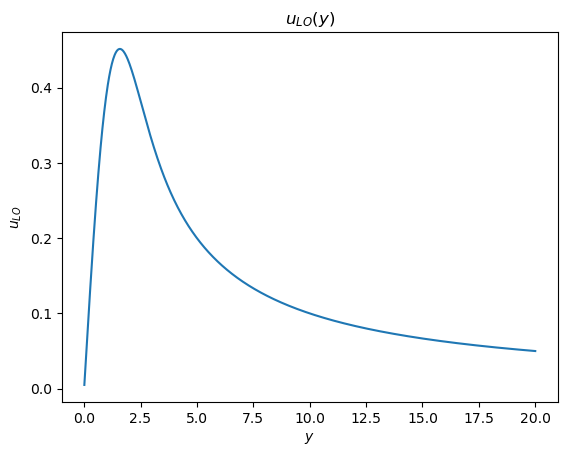

In [3]:
y_vec = np.linspace(0.01, 20, 1000)
u_LO_vec = u_LO(y_vec)
plt.plot(y_vec, u_LO_vec)
plt.title('$u_{LO}(y)$')
plt.xlabel('$y$')
plt.ylabel('$u_{LO}$')
plt.show()

# Bernstein Polynomials

In [5]:
class BernsteinPolynomial:
    def __init__(self, order, *, cutoff=None, w0=[], wN=[]):
        self.order = int(order)
        self.cutoff = cutoff
        self.w0 = np.asanyarray(w0)
        self.len_w0 = len(w0)
        self.wN = np.asanyarray(wN)
        self.len_wN = len(wN)
        
        # Precompute the binomial coefficients
        self.binom_coeffs = sp.special.comb(self.order, np.arange(self.order + 1))
        
    def __call__(self, x0, params):
        if len(params) == self.order + 1 - self.len_w0 - self.len_wN:
            weights = np.concatenate([self.w0,
                                      np.asanyarray(params),
                                      self.wN])
        else:
            raise ValueError(f'The number of the weights does not match the order + 1 of the polynomial ({len(params)} != {self.order + 1 - self.len_w0 - self.len_wN}).')
        
        # If a cutoff is specified, rescale x0 so 
        # t0 \in [0, 1]
        if self.cutoff is not None:
            t0 = x0 / self.cutoff
        else:
            t0 = x0
          
        result = 0
        # deriv_result = 0
        for i in range(self.order + 1):
            result += weights[i] * self.binom_coeffs[i] * t0**i * (1 - t0)**(self.order - i)
            
            # deriv_result += weights[i] * i * self.binom_coeffs[i] * t0**(i-1) * (1 - t0)**(self.order - i) - weights[i] * (self.order - i) * self.binom_coeffs[i] * t0**i * (1 - t0)**(self.order - i - 1)
            
            
        return result  # , deriv_result
        
        
        

In [6]:
order = 4
bp = BernsteinPolynomial(order)
bp(0.5, np.ones(order + 1))

1.0

## Validating the Bernstein Polynomial class

In [7]:
def BP2(x, beta):
    return beta[0] * (1 - x)**2 + beta[1] * 2 * x * (1 - x) + beta[2] * x**2

def BP4(x, beta):
    return beta[0] * (1 - x)**4 + beta[1] * 4 * x * (1 - x)**3 + beta[2] * 6 * x**2 * (1 - x)**2 + beta[3] * 4 * x**3 * (1 - x) + beta[4] * x**4

In [8]:
beta = np.arange(5)
x0 = 0.12
print(BP4(x0, beta))

0.48000000000000004


Error = 0.0


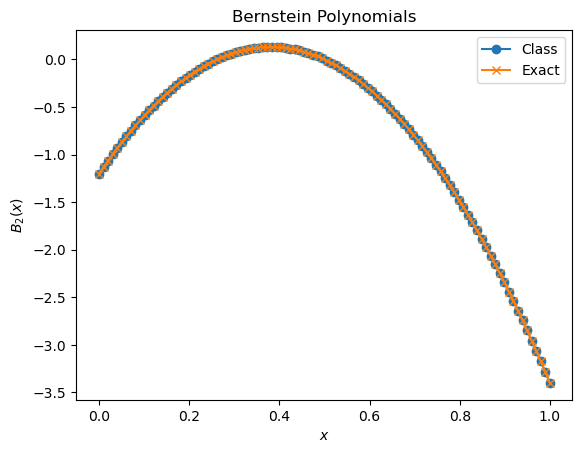

In [9]:
order = 2
num_pts = 100
x_vec = np.linspace(0, 1, num_pts)
wts = [-1.2, 2.3, -3.4]
bp = BernsteinPolynomial(order)
y_vec = np.array([bp(x, wts) for x in x_vec])
y_vec_exact = BP2(x_vec, wts)
print('Error =', np.linalg.norm(y_vec - y_vec_exact))
plt.plot(x_vec, y_vec, 'o-', label='Class')
plt.plot(x_vec, y_vec_exact, 'x-', label='Exact')
plt.legend()
plt.title('Bernstein Polynomials')
plt.xlabel('$x$')
plt.ylabel('$B_2(x)$')
plt.show()

wts = [-3.46469651  5.74386482 -0.14651744  5.43908392  0.07297916]
Error = 0.0


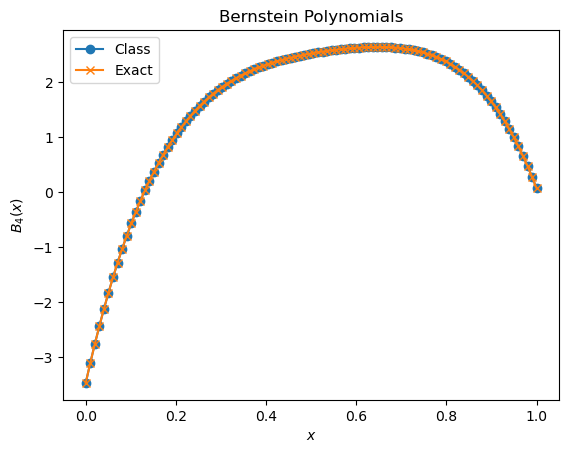

In [10]:
order = 4
num_pts = 100
x_vec = np.linspace(0, 1, num_pts)
wts = np.random.default_rng().uniform(-10, 10, order + 1)
print('wts =', wts)
bp = BernsteinPolynomial(order)
y_vec = bp(x_vec, wts)
y_vec_exact = BP4(x_vec, wts)
print('Error =', np.linalg.norm(y_vec - y_vec_exact))
plt.plot(x_vec, y_vec, 'o-', label='Class')
plt.plot(x_vec, y_vec_exact, 'x-', label='Exact')
plt.legend()
plt.title('Bernstein Polynomials')
plt.xlabel('$x$')
plt.ylabel('$B_4(x)$')
plt.show()

num_free_wts = 7
wts = [-0.89695238  0.43257473  0.68032535 -0.68697659 -0.35349729 -0.94255638
 -0.37787133]


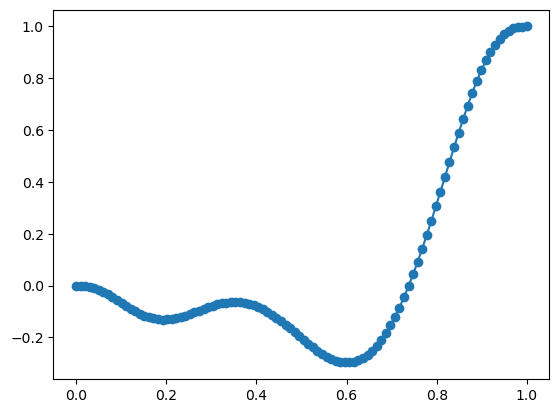

In [11]:
order = 12
num_pts = 100
bp = BernsteinPolynomial(order, w0=[0, 0, 0], wN=[1, 1, 1])
num_free_wts = bp.order + 1 - len(bp.w0) - len(bp.wN)
print('num_free_wts =', num_free_wts)
wts = np.random.default_rng().uniform(-1, 1, num_free_wts)
print('wts =', wts)
x_vec = np.linspace(0, 1, num_pts)
y_vec = bp(x_vec, wts)
plt.plot(x_vec, y_vec, 'o-')
plt.show()

## Fitting the weight function

In [54]:
order = 12
# wf = BernsteinPolynomial(order, cutoff=5)
wf = BernsteinPolynomial(order, w0=[0, 0], wN=[1, 1, 1], cutoff=5)

# Bio-Savart law with Bernstein polynomial weight function
def u_w(y_vec, *weights):
    # Assume y is an array
    
    def integrand(x, y, weights):
        # x & y can be floats or arrays
        mag_xi = np.sqrt(y**2 + x**2)
        return y * wf(mag_xi, weights) / mag_xi**3
    
    sol_vec = []
    # Loop through all the field points used 
    # for fitting
    for y in y_vec:
        if y < wf.cutoff:  # inside cutoff radius
            sol_vec.append(sp.integrate.quad(integrand, 0, wf.cutoff, args=(y, weights))[0] + (1 / y) - (wf.cutoff / (y * np.sqrt(wf.cutoff**2 + y**2))))
        else:  # outside the cutoff radius, use unweighted BS law
            sol_vec.append(1 / y)
    
    return np.array(sol_vec)



In [57]:
# Fitting the weight function to the Lamb-Oseen vortex

# We can't start at 0, however we use it here so the
# divisions are nice numbers, then we change the
# first value to a small number.
y_vec = np.linspace(0, 10, 100)
y_vec[0] = 1e-3

# u_LO_vec = np.ones_like(y_vec)
u_LO_vec = u_LO(y_vec)

# Initial guess for the weight function.
# Maybe try random initialization?

num_params = order + 1 - len(wf.w0) - len(wf.wN)
# w0 = np.zeros(num_weights)
# w0 = np.ones(num_weights)
p0 = np.linspace(0, 1, num_params)
# w0 = np.random.default_rng().uniform(-1, 1, order - 4)
print('p0 =', p0)
optw = sp.optimize.curve_fit(u_w, y_vec, u_LO_vec, p0=p0)[0]
print('optw =', optw)

p0 = [0.         0.14285714 0.28571429 0.42857143 0.57142857 0.71428571
 0.85714286 1.        ]
optw = [0.00154761 0.13684275 0.65331541 1.15005419 0.92884454 0.9615345
 1.01343421 1.00848695]


Error = 0.00041729935330714725
Mean Squared Error = 4.172993533071473e-05


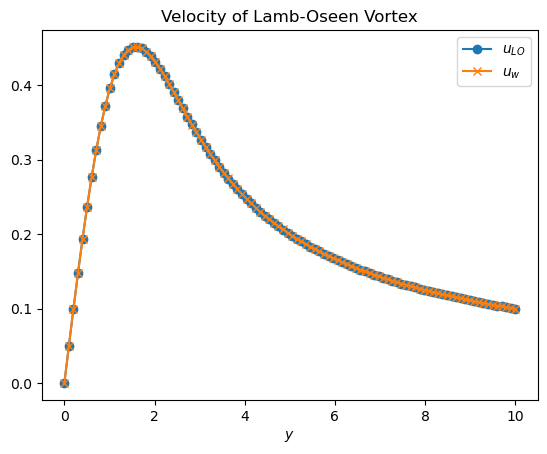

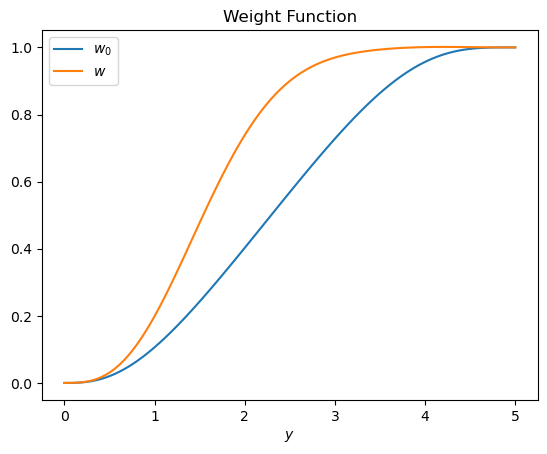

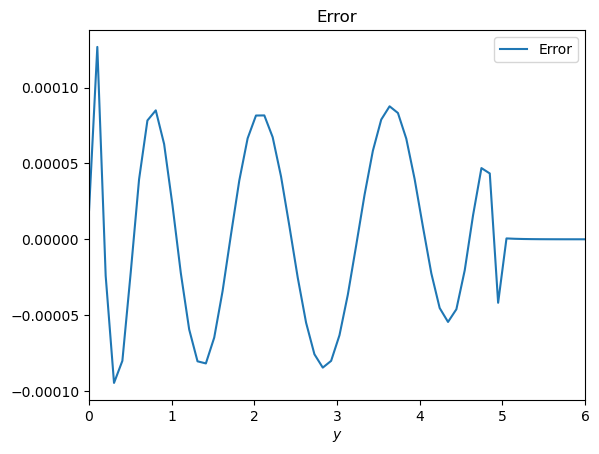

In [58]:
# Plot results

u_w_vec = u_w(y_vec, *optw)
print('Error =', np.linalg.norm(u_w_vec - u_LO_vec))
print('Mean Squared Error =', np.sqrt(np.mean((u_w_vec - u_LO_vec)**2)))

plt.plot(y_vec, u_LO_vec, 'o-', label='$u_{LO}$')
plt.plot(y_vec, u_w_vec, 'x-', label='$u_w$')
plt.legend()
plt.title('Velocity of Lamb-Oseen Vortex')
plt.xlabel('$y$')
plt.show()

y_wf_vec = np.linspace(0, 5, 100)
wf0_vec = wf(y_wf_vec, p0)
wf_vec = wf(y_wf_vec, optw)
plt.plot(y_wf_vec, wf0_vec, label='$w_0$')
plt.plot(y_wf_vec, wf_vec, label='$w$')
plt.title('Weight Function')
plt.xlabel('$y$')
plt.legend()
plt.show()

plt.plot(y_vec, u_w_vec - u_LO_vec, label='Error')
plt.title('Error')
plt.xlabel('$y$')
plt.legend()
plt.xlim([0, 6])
plt.show()